In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings 
warnings.filterwarnings('ignore')  #ignore warnings

In [4]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,Date,Exchange Rate (USD/INR),Exchange_Rate_Lag_1,Exchange_Rate_Lag_3,Exchange_Rate_MA_3,Exchange_Rate_Volatility_7,Exchange_Rate_Percent_Change,NIFTY,S&P500,NIFTY_Lag_1,...,GDP Rate India,GDP Rate USA,GDP_India_Change,GDP_USA_Change,Exports,Imports,Unemployment_Rate_India,US_Unemployment_Rate,Dollar_Index,Dollar_Index_Percent_Change
0,2015-01-01,63.028,63.028,63.515,63.144667,0.128137,0.000000,8395.45,2058.2,8395.45,...,4.062019,3.6,0.5,8.087027,1543.6,3653.9,2.174752,0.111151,103.7607,0.013568
1,2015-01-02,63.270,63.028,63.378,63.108667,0.125187,0.003840,8395.45,2058.2,8395.45,...,4.062019,3.6,0.5,8.087027,1616.2,3316.4,2.174752,0.111151,105.1685,0.013568
2,2015-01-03,63.270,63.270,63.028,63.189333,0.119681,0.000000,8395.45,2058.2,8395.45,...,4.062019,3.6,0.5,8.087027,1816.5,4116.3,2.174752,0.111151,107.3647,0.020883
3,2015-01-04,63.270,63.270,63.028,63.270000,0.110198,0.000000,8395.45,2058.2,8395.45,...,4.000000,2.5,0.5,8.087027,1945.6,4120.3,2.174752,0.111151,106.3523,-0.009430
4,2015-01-05,63.338,63.270,63.270,63.292667,0.095794,0.001075,8378.40,2020.6,8395.45,...,4.000000,2.5,0.5,8.087027,1788.3,4042.0,2.174752,0.111151,105.4065,-0.008893


In [5]:
# print(df.isna().sum())

In [6]:
#Outlier Detection
X = df.drop(['Date'], axis=1)

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR)))
print(outliers.sum())  # Count of outliers in each column

Exchange Rate (USD/INR)           0
Exchange_Rate_Lag_1               0
Exchange_Rate_Lag_3               0
Exchange_Rate_MA_3                0
Exchange_Rate_Volatility_7        0
Exchange_Rate_Percent_Change    656
NIFTY                             0
S&P500                            0
NIFTY_Lag_1                       0
SP500_Lag_1                       0
NIFTY_Percent_Change            151
SP500_Percent_Change            254
Interest Rate USA                 0
Interest Rate India               0
Inflation_Rate_India            720
Inflation_Rate_US                23
GDP Rate India                   12
GDP Rate USA                      9
GDP_India_Change                731
GDP_USA_Change                  369
Exports                           0
Imports                           0
Unemployment_Rate_India         395
US_Unemployment_Rate              0
Dollar_Index                      0
Dollar_Index_Percent_Change       0
dtype: int64


In [7]:
normalized_df = df.copy()
def cap_outliers(normalized_df, cols):
    for col in cols:
        Q1 = normalized_df[col].quantile(0.25)
        Q3 = normalized_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        normalized_df[col] = normalized_df[col].clip(lower=lower_bound, upper=upper_bound)  
    return normalized_df

outlier_cols = [
    'Exchange_Rate_Percent_Change', 'NIFTY_Percent_Change', 'SP500_Percent_Change',
    'Inflation_Rate_India', 'Inflation_Rate_US', 'GDP Rate India', 'GDP Rate USA', 'GDP_India_Change', 
    'GDP_USA_Change', 'Unemployment_Rate_India'
]

normalized_df = cap_outliers(normalized_df, outlier_cols)

In [8]:
#cap the outliers
X = normalized_df.drop(['Date'], axis=1, errors='ignore')

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X_capped = X.copy()
for col in X_capped.columns:
    X_capped[col] = X_capped[col].clip(lower=lower_bound[col], upper=upper_bound[col])

print(X_capped.isna().sum().sum())  # Should be 0 if handled correctly

0


In [9]:
# print(X.isna().sum().sum())  # Total NaNs before capping
# print(X.isna().sum())

In [10]:
# normalized_df.isnull().sum()

In [11]:
import pandas as pd
import numpy as np
import joblib  
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if 'Date' in df.columns:
    df = df.drop(columns=['Date'])
if 'Date' in normalized_df.columns:
    normalized_df = normalized_df.drop(columns=['Date'])

target_col = 'Exchange Rate (USD/INR)'
X = normalized_df.drop(columns=[target_col])  # Features
y = normalized_df[[target_col]]               # Target

#standard scaler for Regression
scaler_std_X = StandardScaler()
scaler_std_y = StandardScaler()
X_std = scaler_std_X.fit_transform(X)
y_std = scaler_std_y.fit_transform(y)  

# MinMaxScaler For LSTM
scaler_minmax_X = MinMaxScaler()
scaler_minmax_y = MinMaxScaler()
X_minmax = scaler_minmax_X.fit_transform(X)
y_minmax = scaler_minmax_y.fit_transform(y)  

# No Scaling For Random Forest & XGBoost
X_raw = df.drop(columns=[target_col]).values
y_raw = df[[target_col]].values


print(f"X Standardized Shape: {X_std.shape}")
print(f"X MinMax Shape: {X_minmax.shape}")
print(f"X Raw Shape (No Scaling): {X_raw.shape}")

# Save scalers 
joblib.dump(scaler_std_X, "standard_X.pkl")
joblib.dump(scaler_std_y, "standard_y.pkl")
joblib.dump(scaler_minmax_X, "minmax_X.pkl")
joblib.dump(scaler_minmax_y, "minmax_y.pkl")
print("\nScalers saved successfully!")

#load Scalers
scaler_std_X = joblib.load("standard_X.pkl")
scaler_std_y = joblib.load("standard_y.pkl")
scaler_minmax_X = joblib.load("minmax_X.pkl")
scaler_minmax_y = joblib.load("minmax_y.pkl")
print("\nScalers loaded successfully!")

X Standardized Shape: (3733, 25)
X MinMax Shape: (3733, 25)
X Raw Shape (No Scaling): (3733, 25)

Scalers saved successfully!

Scalers loaded successfully!


<h1>Linear Regression<h1>

In [23]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

X_train, X_test = X_std[:-int(len(X_std) * 0.2)], X_std[-int(len(X_std) * 0.2):]
y_train, y_test = y_std[:-int(len(y_std) * 0.2)], y_std[-int(len(y_std) * 0.2):]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (2987, 25), Test size: (746, 25)


In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (alpha=1)": Ridge(alpha=1),
    "Ridge (alpha=10)": Ridge(alpha=10),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1),
    "ElasticNet (alpha=0.1, l1_ratio=0.5)": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

tscv = TimeSeriesSplit(n_splits=5)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train.ravel())  
    y_pred = model.predict(X_test)  

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results[name] = (r2, rmse, mape)
    print(f"{name}: R²={r2:.4f}, RMSE={rmse:.4f}, MAPE={mape:.4f}")

best_model = max(results, key=lambda k: results[k][0])  # Best R² Score
print(f"\n✅ Best Model: {best_model} with R²={results[best_model][0]:.4f}")


LinearRegression: R²=0.9991, RMSE=0.0054, MAPE=0.0026
Ridge (alpha=1): R²=0.9991, RMSE=0.0055, MAPE=0.0027
Ridge (alpha=10): R²=0.9967, RMSE=0.0106, MAPE=0.0058
Lasso (alpha=0.1): R²=-2.5562, RMSE=0.3475, MAPE=0.2335
ElasticNet (alpha=0.1, l1_ratio=0.5): R²=-1.3472, RMSE=0.2823, MAPE=0.1887

✅ Best Model: LinearRegression with R²=0.9991


In [25]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

best_model = Ridge(alpha=1)
best_model.fit(X_train, y_train)

cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
cv_rmse = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
cv_mape = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

print(f"✅ Cross-Validation R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"✅ Cross-Validation RMSE: {cv_rmse.mean():.4f}")
print(f"✅ Cross-Validation MAPE: {-cv_mape.mean():.4f}")

y_pred = best_model.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")

joblib.dump(best_model, 'best_ridge_model.pkl')
print("✅ Model saved successfully!")

loaded_model = joblib.load('best_ridge_model.pkl')
new_predictions = loaded_model.predict(X_test[:5]) 
print("Predictions on new data:", new_predictions)


✅ Cross-Validation R²: 0.9959 ± 0.0036
✅ Cross-Validation RMSE: 0.0152
✅ Cross-Validation MAPE: 0.0888
Test R²: 0.9991
Test RMSE: 0.0055
Test MAPE: 0.0027
✅ Model saved successfully!
Predictions on new data: [1.259412   1.24741571 1.26780295 1.24939105 1.2546104 ]


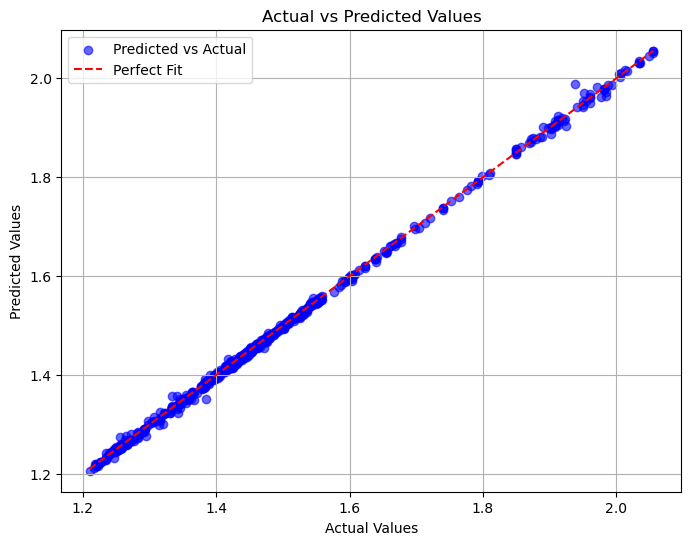

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test MAE: {mae:.4f}")


Test R²: 0.9991
Test RMSE: 0.0055
Test MAPE: 0.0027
Test MAE: 0.0039


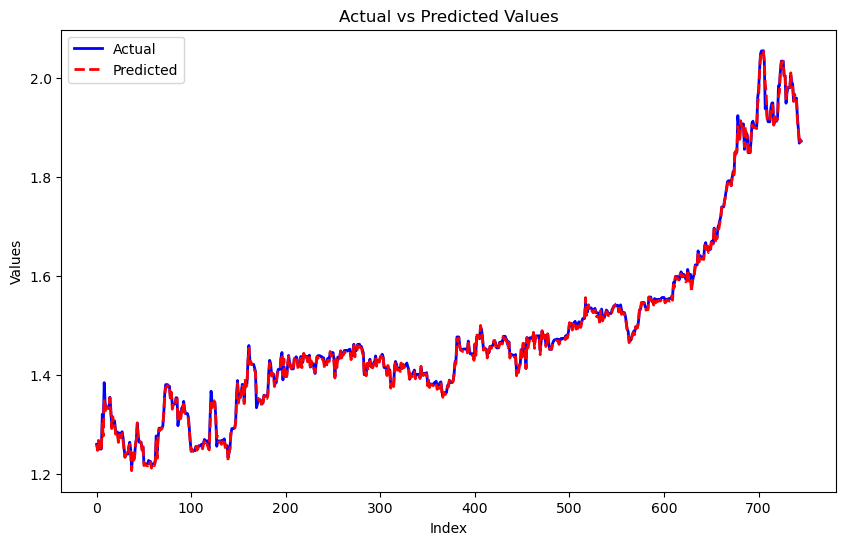

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_test, label='Actual', color='blue', linewidth=2)

plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

plt.xlabel("Index")  
plt.ylabel("Values")  
plt.title("Actual vs Predicted Values")  

plt.legend()

plt.show()

<h1>Random Forest</h1>

In [16]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

X_train, X_test = X_raw[:-int(len(X_raw) * 0.2)], X_raw[-int(len(X_raw) * 0.2):]
y_train, y_test = y_raw[:-int(len(y_raw) * 0.2)], y_raw[-int(len(y_raw) * 0.2):]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (2987, 25), Test size: (746, 25)


In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train.ravel())

best_rf = grid_search.best_estimator_
print('--'*50)
print(f"Best Hyperparameters: {grid_search.best_params_}")

y_pred = best_rf.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------------------------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test R²: -0.3049
Test RMSE: 1.4850
Test MAPE: 0.0108


In [18]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor

# # Ensure X_train is a DataFrame
# if isinstance(X_train, np.ndarray):
#     X_train = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
#     X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

# # Train Random Forest model with best hyperparameters
# rf_model = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
# rf_model.fit(X_train, y_train.ravel())  # Convert y_train to 1D using ravel()

# # Extract Feature Importance
# feature_importance = rf_model.feature_importances_
# feature_names = X_train.columns  # Now it works

# # Create a DataFrame for visualization
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Plot Feature Importance
# plt.figure(figsize=(12, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
# plt.xlabel("Feature Importance")
# plt.ylabel("Features")
# plt.title("Feature Importance in Random Forest Model")
# plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
# plt.show()

# # Set threshold for feature selection
# importance_threshold = 0.01  # Features with less than 1% importance will be removed

# # Select important features
# selected_features = importance_df[importance_df['Importance'] >= importance_threshold]['Feature'].tolist()
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# print(f"✅ Selected {len(selected_features)} important features out of {X_train.shape[1]}")


Test R²: -0.2893
Test RMSE: 1.4762
Test MAPE: 0.0107
✅ Model saved successfully!


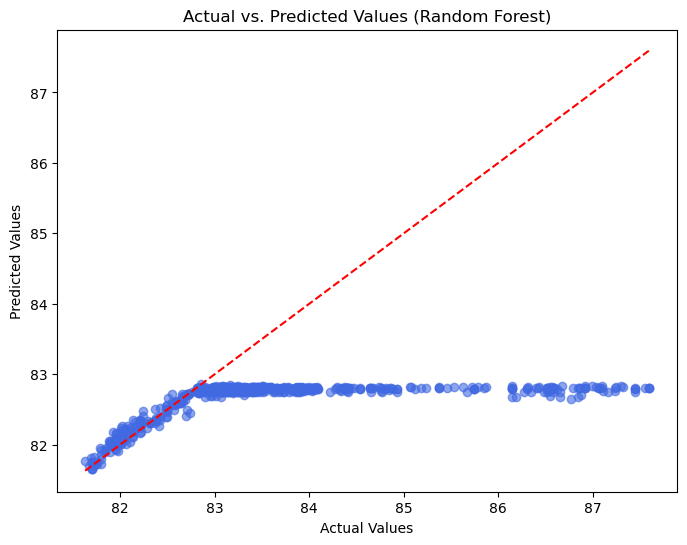

In [19]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
    X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

best_rf_model = RandomForestRegressor(max_depth= 15, max_features= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 50)
best_rf_model.fit(X_train, y_train.ravel())  # Convert y_train to 1D using ravel()

y_pred = best_rf_model.predict(X_test)

print(f"Test R²: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")

joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
print("\u2705 Model saved successfully!")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='royalblue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Random Forest)")
plt.show()


<h1>XGBoost</h1>

In [81]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

X_train, X_test = X_raw[:-int(len(X_raw) * 0.2)], X_raw[-int(len(X_raw) * 0.2):]
y_train, y_test = y_raw[:-int(len(y_raw) * 0.2)], y_raw[-int(len(y_raw) * 0.2):]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (2987, 25), Test size: (746, 25)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
                                                params  mean_test_score  \
0    {'colsample_bytree': 0.8, 'learning_rate': 0.0...        -3.225607   
1    {'colsample_bytree': 0.8, 'learning_rate': 0.0...        -3.220337   
2    {'colsample_bytree': 0.8, 'learning_rate': 0.0...        -0.915081   
3    {'colsample_bytree': 0.8, 'learning_rate': 0.0...        -0.912385   
4    {'colsample_bytree': 0.8, 'learning_rate': 0.0...         0.371856   
..                                                 ...              ...   
103  {'colsample_bytree': 1.0, 'learning_rate': 0.3...         0.660658   
104  {'colsample_bytree': 1.0, 'learning_rate': 0.3...         0.660666   
105  {'colsample_bytree': 1.0, 'learning_rate': 0.3...         0.660658   
106  {'colsample_bytree': 1.0, 'learning_rate': 0.3...         0.660673   
107  {'colsample_bytree': 1.0, 'learning_rate': 0.3...         0.660658   

     std_test_score  
0          2.2

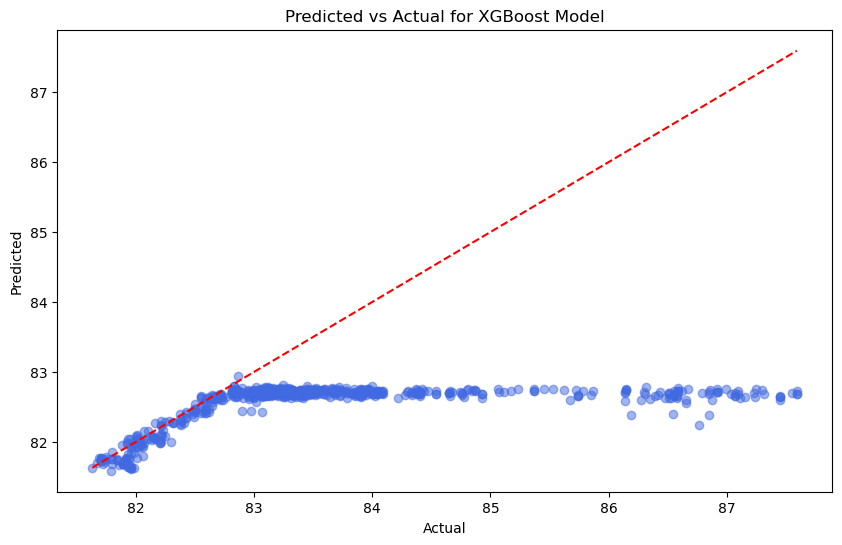

✅ Best XGBoost Model saved successfully!


In [82]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import joblib

xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train.ravel())

grid_results = pd.DataFrame(grid_search.cv_results_)
print(grid_results[['params', 'mean_test_score', 'std_test_score']])
print('--'*50)
best_xgb = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

y_pred = best_xgb.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='royalblue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual for XGBoost Model")
plt.show()

joblib.dump(best_xgb, 'best_xgb_model.pkl')
print("✅ Best XGBoost Model saved successfully!")


In [21]:
# !pip install --upgrade scikit-learn xgboost

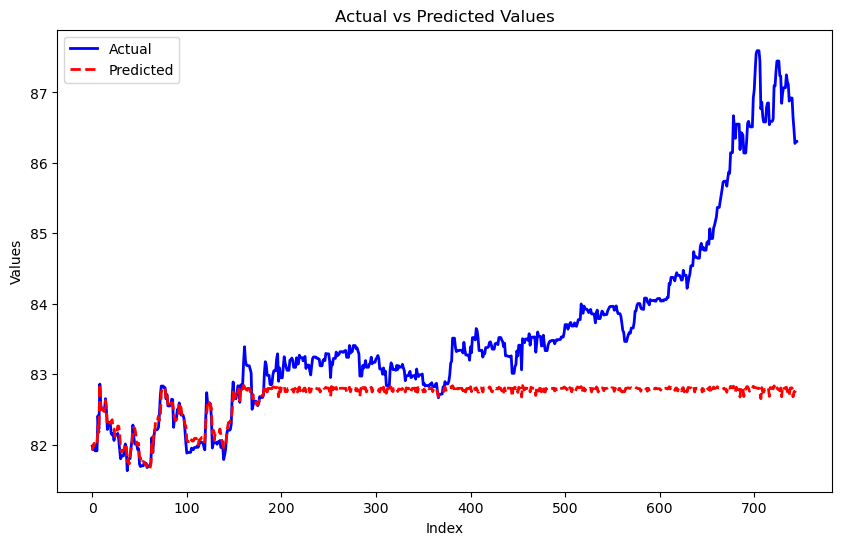

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_test, label='Actual', color='blue', linewidth=2)

plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

plt.xlabel("Index")  
plt.ylabel("Values")  
plt.title("Actual vs Predicted Values") 

plt.legend()
plt.show()


<h1>LSTM</h1>

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, ParameterSampler
from sklearn.metrics import r2_score

In [13]:
X_minmax = X_minmax.reshape((X_minmax.shape[0], X_minmax.shape[1], 1))

In [14]:
train_size = int(len(X_minmax) * 0.8)
X_train, X_test = X_minmax[:train_size], X_minmax[train_size:]
y_train, y_test = y_minmax[:train_size], y_minmax[train_size:]

In [15]:
# !pip uninstall tensorflow keras

In [16]:
# !pip install keras==2.11.0 tensorflow==2.11.0

In [17]:
tf.random.set_seed(42)
def build_lstm_model(units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(dropout_rate),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [39]:
param_grid = {
    'units': [40, 50, 60],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [50, 75, 100]
}

param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))  # Random sampling

# build LSTM model
def build_lstm_model(units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(dropout_rate),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Nested Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_r2 = -np.inf
best_params = None

for params in param_list:
    print(f"Trying parameters: {params}")

    fold_r2_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = build_lstm_model(params['units'], params['dropout_rate'], params['learning_rate'])
        model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

        y_pred_val = model.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred_val)
        fold_r2_scores.append(r2)
    
    avg_r2 = np.mean(fold_r2_scores)
    print(f"Average R² Score: {avg_r2}")

    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_params = params

print("\nBest Parameters:", best_params)
print("Best Cross-Validation R² Score:", best_r2)

Trying parameters: {'units': 40, 'learning_rate': 0.0001, 'epochs': 100, 'dropout_rate': 0.1, 'batch_size': 16}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Average R² Score: 0.9867595982041812
Trying parameters: {'units': 40, 'learning_rate': 0.0001, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 16}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Average R² Score: 0.9650288219797207
Trying parameters: {'units': 60, 'learning_rate': 0.0001, 'epochs': 75, 'dropout_rate': 0.3, 'batch_size': 32}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29

In [36]:
# Train final model on full training data
final_model = build_lstm_model(40, 0.1, 0.001)
final_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Evaluate on Test Set
y_pred_test = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0354
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0062
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0055
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0056
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0046
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0026
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018
Epoch 13/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0015
Epoch 14/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013
Epoch 15/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - lo

In [30]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nFinal Test R² Score: {test_r2}")
print(f"Final Test RMSE: {test_rmse}")
print(f"Final Test MAE: {test_mae}")


Final Test R² Score: 0.7418827125980553
Final Test RMSE: 0.025175120110134314
Final Test MAE: 0.015628446545165833


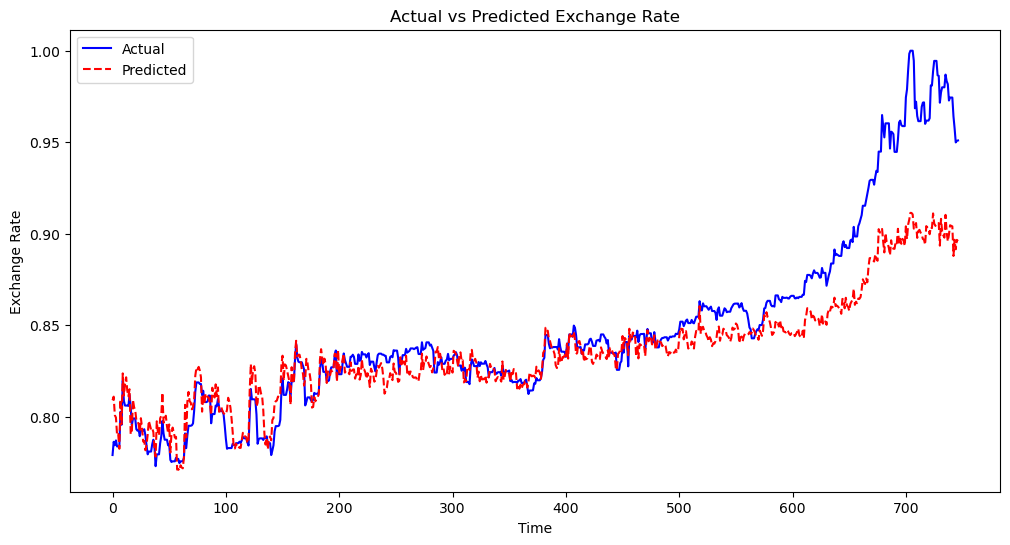

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.title('Actual vs Predicted Exchange Rate')
plt.legend()
plt.show()

In [32]:
model_path = "lstm_exchange_rate_model.h5"
final_model.save(model_path)
print(f"\nModel saved to {model_path}")


Model saved to lstm_exchange_rate_model.h5


In [ ]:
# !pip install scikeras

In [ ]:
# !pip install --upgrade scikit-learn scikeras

In [ ]:
# !pip install --upgrade scikit-learn scikeras tensorflow

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0408 - val_loss: 0.0090
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0035 - val_loss: 0.0127
Epoch 12/100
187/187 ━━━━━━━━━

Model saved successfully!
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


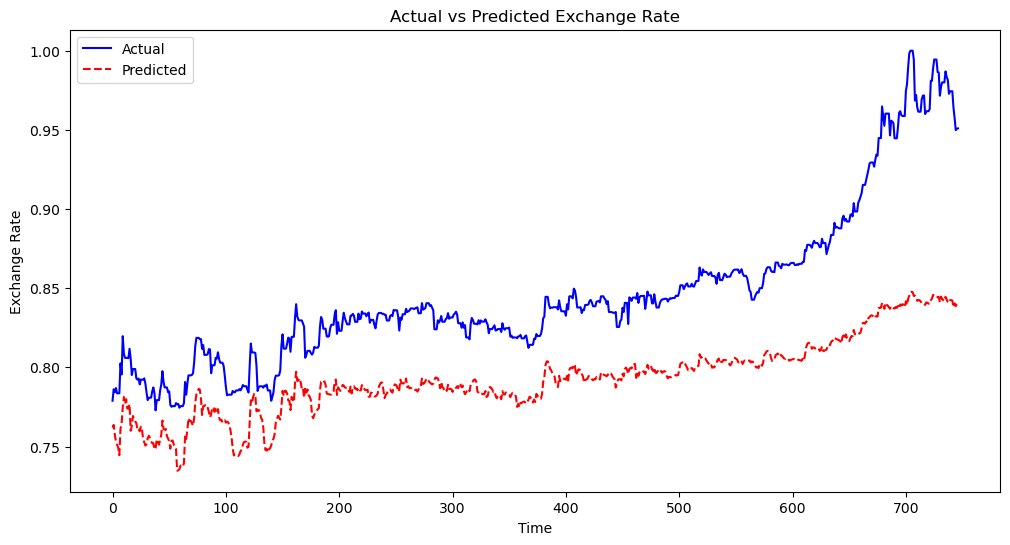

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.optimizers import Adam

# # Best Parameters from Hyperparameter Tuning
# best_params = {
#     'units': 40,
#     'learning_rate': 0.0005,
#     'epochs': 100,
#     'dropout_rate': 0.1,
#     'batch_size': 16
# }

# # Function to build and compile the LSTM model
# def build_lstm_model(units, dropout_rate, learning_rate):
#     model = Sequential()
#     model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(units=units, return_sequences=False))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units=1))
    
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     return model

# # Build the model with best parameters
# model = build_lstm_model(
#     best_params['units'], 
#     best_params['dropout_rate'], 
#     best_params['learning_rate']
# )

# # Train the model
# history = model.fit(
#     X_train, y_train, 
#     epochs=best_params['epochs'], 
#     batch_size=best_params['batch_size'], 
#     validation_data=(X_test, y_test),
#     verbose=1
# )

# # Save the trained model
# model.save("lstm_exchange_rate_model.h5")
# print("Model saved successfully!")

# # Load the model (to verify saving & loading)
# loaded_model = load_model("lstm_exchange_rate_model.h5")

# # Make predictions
# y_pred = loaded_model.predict(X_test)

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label="Actual", color="blue")
# plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
# plt.xlabel("Time")
# plt.ylabel("Exchange Rate")
# plt.title("Actual vs Predicted Exchange Rate")
# plt.legend()
# plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R² Score: 0.620978


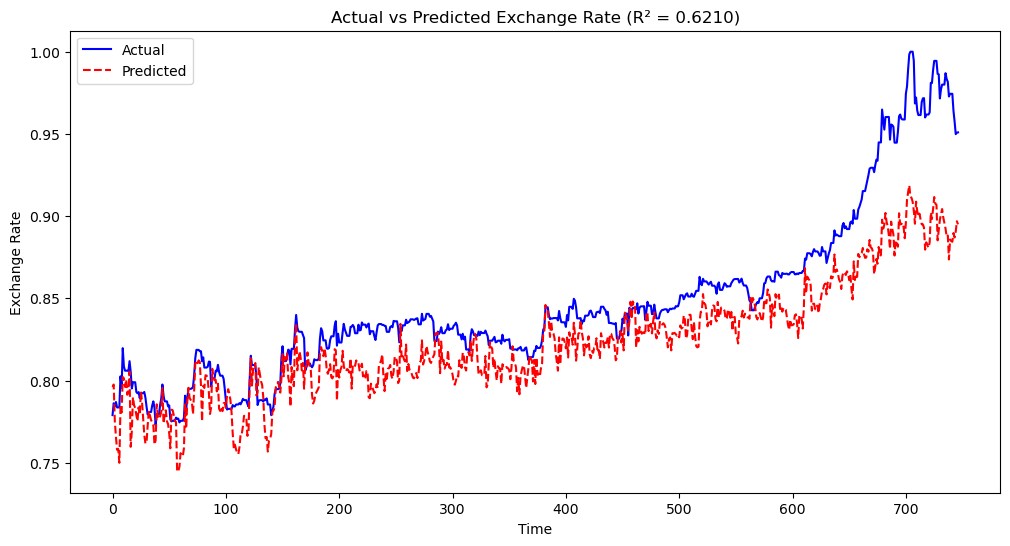

In [46]:
# from sklearn.metrics import r2_score

# # Make predictions
# y_pred = loaded_model.predict(X_test)

# # Compute R-squared (R²) score
# r2 = r2_score(y_test, y_pred)
# print(f"R² Score: {r2:.6f}")  # Print R² with 6 decimal places

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label="Actual", color="blue")
# plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
# plt.xlabel("Time")
# plt.ylabel("Exchange Rate")
# plt.title(f"Actual vs Predicted Exchange Rate (R² = {r2:.4f})")
# plt.legend()
# plt.show()


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0351 - val_loss: 0.0092
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0113 - val_loss: 0.0158
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0086 - val_loss: 0.0053
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0063 - val_loss: 0.0142
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0050 - val_loss: 0.0168
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0055 - val_loss: 0.0084
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0050 - val_loss: 0.0084
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 

Model saved successfully!
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


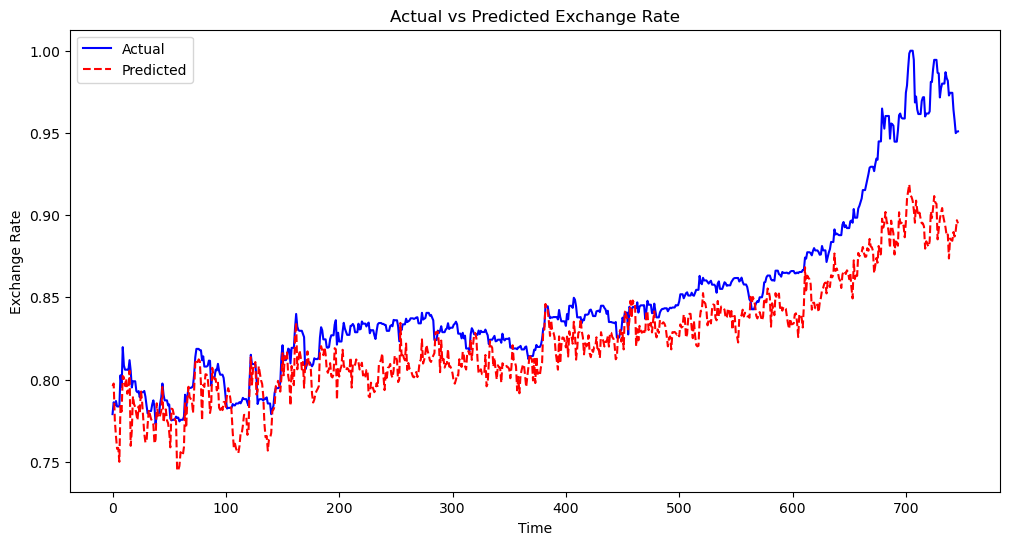

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.optimizers import Adam

# # Best Parameters from Hyperparameter Tuning
# best_params = {
#     'units': 40,
#     'learning_rate': 0.0005,
#     'epochs': 50,
#     'dropout_rate': 0.3,
#     'batch_size': 16
# }

# best_params = {
#     'units': 40,
#     'learning_rate': 0.0005,
#     'epochs': 50,
#     'dropout_rate': 0.3,
#     'batch_size': 16
# }

# # Function to build and compile the LSTM model
# def build_lstm_model(units, dropout_rate, learning_rate):
#     model = Sequential()
#     model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(units=units, return_sequences=False))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units=1))
    
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     return model

# # Build the model with best parameters
# model = build_lstm_model(
#     best_params['units'], 
#     best_params['dropout_rate'], 
#     best_params['learning_rate']
# )

# # Train the model
# history = model.fit(
#     X_train, y_train, 
#     epochs=best_params['epochs'], 
#     batch_size=best_params['batch_size'], 
#     validation_data=(X_test, y_test),
#     verbose=1
# )

# # Save the trained model
# model.save("lstm_exchange_rate_model.h5")
# print("Model saved successfully!")

# # Load the model (to verify saving & loading)
# loaded_model = load_model("lstm_exchange_rate_model.h5")

# # Make predictions
# y_pred = loaded_model.predict(X_test)

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label="Actual", color="blue")
# plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
# plt.xlabel("Time")
# plt.ylabel("Exchange Rate")
# plt.title("Actual vs Predicted Exchange Rate")
# plt.legend()
# plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R² Score: 0.620978


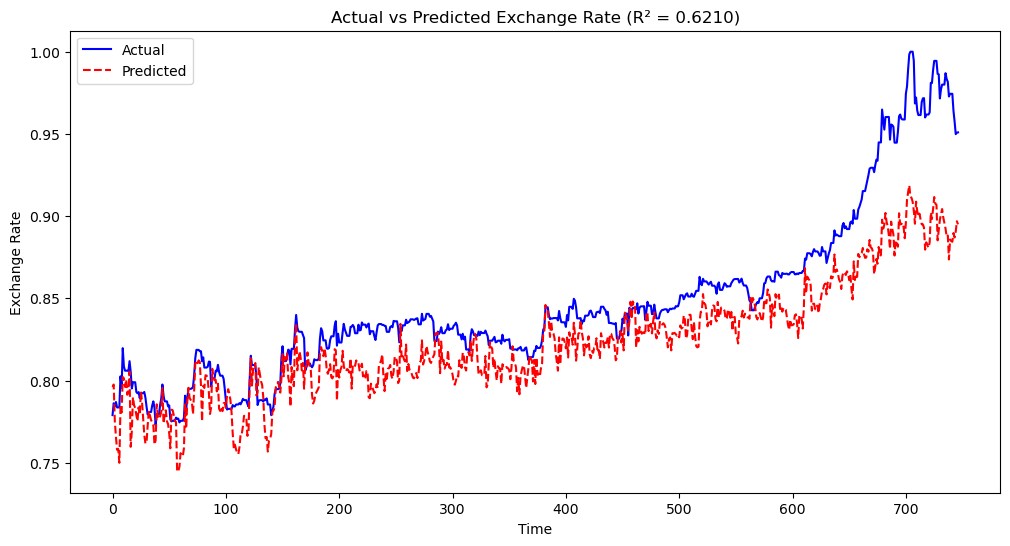

In [31]:
# from sklearn.metrics import r2_score

# # Make predictions
# y_pred = loaded_model.predict(X_test)

# # Compute R-squared (R²) score
# r2 = r2_score(y_test, y_pred)
# print(f"R² Score: {r2:.6f}")  # Print R² with 6 decimal places

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label="Actual", color="blue")
# plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
# plt.xlabel("Time")
# plt.ylabel("Exchange Rate")
# plt.title(f"Actual vs Predicted Exchange Rate (R² = {r2:.4f})")
# plt.legend()
# plt.show()


In [41]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import ParameterSampler
# # from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# # Define the parameter grid
# param_grid = {
#     'units': [40, 50, 60],
#     'dropout_rate': [0.1, 0.2, 0.3, 0.4],
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'batch_size': [16, 32, 64],
#     'epochs': [25, 50, 75, 100]
# }

# # Generate random parameter combinations
# n_iter = 10  # Number of trials
# param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

# # Function to build the LSTM model
# def build_lstm_model(units, dropout_rate, learning_rate):
#     model = Sequential([
#         LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#         Dropout(dropout_rate),
#         LSTM(units=units, return_sequences=False),
#         Dropout(dropout_rate),
#         Dense(units=1)
#     ])
    
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     return model

# # Manual Random Search
# # best_mse = float('inf')
# # best_params = None

# best_r2 = -float('inf')  # Start with lowest possible R²
# best_params = None

# for params in param_list:
#     print(f"Trying parameters: {params}")

#     model = build_lstm_model(params['units'], params['dropout_rate'], params['learning_rate'])
    
#     model.fit(X_train_split, y_train_split, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    
#     y_pred = model.predict(X_val)
#     # mse = mean_squared_error(y_val, y_pred)

#     # print(f"MSE: {mse}")
#     r2 = r2_score(y_val, y_pred)
#     print(f"R² Score: {r2}")

#     # Track best parameters
#     if r2 > best_r2:
#         best_r2 = r2
#         best_params = params

# print("\nBest Parameters:", best_params)
# # print("Best MSE:", best_mse)
# print("Best R² Score:", best_r2)
